In [124]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
#import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import ndimage

In [125]:
step_yr=1
years=np.arange(2020,2101,step_yr)
years

array([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
       2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074,
       2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085,
       2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096,
       2097, 2098, 2099, 2100])

In [126]:
# Define GMT scenarios

scens = ["stabil_15", "PW_165", "stayatpeak_165", "PW_18"]

PW = 1.65
yr_start = 2020
yr_15_befov = 2040
yr_PW = 2060
yr_15_aftov = 2080

GMT=np.zeros((len(scens),len(years)))

for sc in range(len(scens)):
    for i in range(len(years)):
        if years[i] <= yr_15_befov:
            GMT[sc,i] = 1.5 - (yr_15_befov-years[i])*(1.5-1.2)/(yr_15_befov-yr_start)
        if years[i] > yr_15_befov and years[i] <= yr_PW:
            if scens[sc] == "stabil_15": 
                GMT[sc,i] = 1.5
            elif scens[sc] == "PW_165" or scens[sc] == "stayatpeak_165":
                GMT[sc,i] = PW - (yr_PW-years[i])*(PW-1.5)/(yr_PW-yr_15_befov)
            elif scens[sc] == "PW_18":
                GMT[sc,i] = 1.8 - (yr_PW-years[i])*(1.8-1.5)/(yr_PW-yr_15_befov)
        elif years[i] > yr_PW and years[i] <= yr_15_aftov:
            if scens[sc] == "stabil_15": 
                GMT[sc,i] = 1.5
            elif scens[sc] == "PW_165":
                GMT[sc,i] = PW - (years[i]-yr_PW)*(PW-1.5)/(yr_15_aftov-yr_PW)
            elif scens[sc] == "stayatpeak_165":
                GMT[sc,i] = 1.65
            elif scens[sc] == "PW_18":
                GMT[sc,i] = 1.8 - (years[i]-yr_PW)*(1.8-1.5)/(yr_15_aftov-yr_PW)
        elif years[i] > 2060:
            if scens[sc] == "PW_165" or scens[sc] == "stabil_15":
                GMT[sc,i] = 1.5
            elif scens[sc] == "stayatpeak_165":
                GMT[sc,i] = 1.65
            elif scens[sc] == "PW_18":
                GMT[sc,i] = 1.5

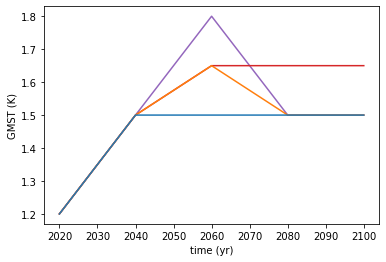

In [127]:
# Plot the GMT trajectories
    
plt.plot(years,GMT[3,:], color='C4')
plt.plot(years,GMT[2,:], color='C3')
plt.plot(years,GMT[1,:], color='C1')
plt.plot(years,GMT[0,:], color='C0')
    
plt.xlabel('time (yr)')
plt.ylabel('GMST (K)')
plt.show()

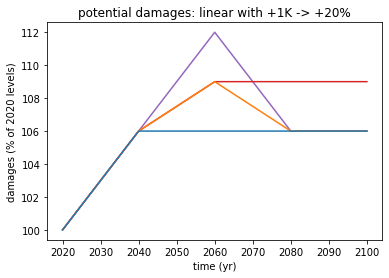

In [128]:
# Plot the relative change in damages from Global Warming if there is no adaptation

# Define damage coefficients from global warming
#dam_coeff = (GMT-GMT[0,0])/GMT[0,0]
dam_coeff = 100 + (GMT-GMT[0,0])*20 # damages linear with GW, +1K brings +20% damages

# plot damages
plt.figure()

plt.plot(years,dam_coeff[3,:], color='C4')
plt.plot(years,dam_coeff[2,:], color='C3')
plt.plot(years,dam_coeff[1,:], color='C1')
plt.plot(years,dam_coeff[0,:], color='C0')
    
plt.title('potential damages: linear with +1K -> +20%')
plt.xlabel('time (yr)')
plt.ylabel('damages (% of 2020 levels)')
plt.show()

In [199]:
# When reaching 1.5°C in 2040, and knowing that there would be an overshoot of 40 years:
# do we rather want to adapt to 1.5°C or to the peak warming during the length of the overshoot?

# assuming damages evolve linearly with GW
# assuming no economic growth

# Plot the total costs = costs of adaptation + damages - avoided damages 

dash_patterns=['solid','dotted','dashed','dashdot','solid']

# We're looking at a 1-in-100-year event
p_ev = 0.01


# Range of parameters to scan in the sensitivity analysis
disc_rate = np.arange(0.,6.,2)  # time discounting rate
ec_growth = np.arange(0.,6.,2)  # economic growth
perc_av_dam = range(10,110,10)  # Percentage of the damages avoided through adaptation
adcosts_perc_dam = range(5,35,5)  # adaptation costs (expressed as a percentage of the damages)


adcosts = np.empty([2,len(scens)])
dam = np.empty([len(scens),len(disc_rate),len(ec_growth),len(years)])
av_dam = np.empty([2,len(scens),len(disc_rate),len(ec_growth),len(years)])
net_dam = np.empty([2,len(scens),len(disc_rate),len(ec_growth),len(years)])
tot_dam = np.empty([2,len(scens),len(disc_rate),len(ec_growth)])
ratio_costs_options = np.empty([len(scens),len(disc_rate),len(ec_growth),len(perc_av_dam),len(adcosts_perc_dam)])

cutoff = 0.1 # How many times higher the cost of an adaptation option should be compared to the damages it allows avoiding for it to be even considered?

#Debugging#
A = np.empty([2,len(scens),len(disc_rate),len(ec_growth),len(perc_av_dam),len(years)])
B = np.empty([2,len(scens),len(disc_rate),len(ec_growth),len(perc_av_dam),len(years)])
#Debugging#

for di in range(len(disc_rate)):
    
    print('discount rate')
    print(disc_rate[di])
    
    for gr in range(len(ec_growth)):
        
        print('growth')
        print(ec_growth[gr])
        
        for avd in range(len(perc_av_dam)):
            
            print('avoided damages (%)')
            print(perc_av_dam[avd])
            
            for adc in range(len(adcosts_perc_dam)):
    
                if perc_av_dam[avd] >= adcosts_perc_dam[adc]*cutoff:

                    # Costs of adaptation
                    ## Option 1: Costs of adapting to damage level at GMT = 1.5°C
                    adcosts[0,:] = np.squeeze(adcosts_perc_dam[adc]/100*dam_coeff[:,np.where(years==yr_15_befov)[0]])
    
                    ## Option 2: Costs of adapting to damage level at Peak Warming
                    adcosts[1,:] = np.squeeze(adcosts_perc_dam[adc]/100*dam_coeff[:,np.where(years==yr_PW)[0]])

            
                    for yr in range(int(np.where(years==yr_15_befov+1)[0]),int(np.where(years==yr_15_aftov+1)[0]),step_yr):

                        #print(years[yr])
                    
                        # Damages in case of an event, taking both the time discounting rate and economic growth into account
                        dam[:,di,gr,yr] = dam_coeff[:,yr]*((1-disc_rate[di]/100)*(1+ec_growth[gr]/100))**(years[yr]-yr_15_befov)           
                
                
                        # Damages avoided through adaptation in case of an event, taking the time discounting rate into account
                        ## Option 1: when adaptating to damage level at GMT = 1.5°C
                        av_dam[0,:,di,gr,yr] = np.squeeze(perc_av_dam[avd]/100*dam_coeff[:,np.where(years==yr_15_befov)[0]]*((1-disc_rate[di]/100)*(1+ec_growth[gr]/100))**(years[yr]-yr_15_befov))
                        
                        #DEBUGGING
                        A[0,:,di,gr,avd,yr] = av_dam[0,:,di,gr,yr]
        
                        ## Option 2: when adaptating to damage level at Peak Warming
                        av_dam[1,:,di,gr,yr] = np.squeeze(perc_av_dam[avd]/100*dam_coeff[:,np.where(years==yr_PW)[0]]*((1-disc_rate[di]/100)*(1+ec_growth[gr]/100))**(years[yr]-yr_15_befov))
                       
                        #DEBUGGING
                        A[1,:,di,gr,avd,yr] = av_dam[1,:,di,gr,yr]
        
                
                        # Expected net damages (damages - damages avoided through adaptation), considering that event happens in year yr and hasn't happened before
                       
                        for sc in range(len(scens)):
                            
                            ## Option 1: when adaptating to damage level at GMT = 1.5°C
                            net_dam[0,sc,di,gr,yr] = max((1-p_ev)**(yr-int(np.where(years==yr_15_befov+1)[0]))*p_ev*(dam[sc,di,gr,yr]-av_dam[0,sc,di,gr,yr]),0)
                
                            ## Option 2: when adaptating to damage level at Peak Warming
                            net_dam[1,sc,di,gr,yr] = max((1-p_ev)**(yr-int(np.where(years==yr_15_befov+1)[0]))*p_ev*(dam[sc,di,gr,yr]-av_dam[1,sc,di,gr,yr]),0) 
                        
                        #DEBUGGING
                        B[0,:,di,gr,avd,yr] = net_dam[0,:,di,gr,yr]
                        B[1,:,di,gr,avd,yr] = net_dam[1,:,di,gr,yr]

                    ## DEBUGGING
                    #if di == 1 and gr ==1 and avd == 5:
                        
                    #    A0 = av_dam[0,:,di,gr,:]
                    #    print(A0)
                    #    A1 = av_dam[1,:,di,gr,:]
                    #    print(A1)
                    ##
                    
    
                    # Total expected damages
                    ## Option 1: when adaptating to damage level at GMT = 1.5°C
                    tot_dam[0,:,di,gr] = np.sum(net_dam[0,:,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],1)
    
                    ## Option 2: when adaptating to damage level at Peak Warming
                    tot_dam[1,:,di,gr] = np.sum(net_dam[1,:,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],1)
        
        
                    # Calculate ratio of total costs (net damages + costs of adaptation) when adapting to 1.5°C over total costs when adapting to Peak Warming            
                    ratio_costs_options[:,di,gr,avd,adc] = (tot_dam[0,:,di,gr] + adcosts[0,:]) / (tot_dam[1,:,di,gr] + adcosts[1,:])
    
    
                else:
                    ratio_costs_options[:,di,gr,avd,adc] = np.nan
                                     

# NOT ACCOUNTED FOR:
# costs of re-building and re-adapting

discount rate
0.0
growth
0.0
avoided damages (%)
10
avoided damages (%)
20
avoided damages (%)
30
avoided damages (%)
40
avoided damages (%)
50
avoided damages (%)
60
avoided damages (%)
70
avoided damages (%)
80
avoided damages (%)
90
avoided damages (%)
100
growth
2.0
avoided damages (%)
10
avoided damages (%)
20
avoided damages (%)
30
avoided damages (%)
40
avoided damages (%)
50
avoided damages (%)
60
avoided damages (%)
70
avoided damages (%)
80
avoided damages (%)
90
avoided damages (%)
100
growth
4.0
avoided damages (%)
10
avoided damages (%)
20
avoided damages (%)
30
avoided damages (%)
40
avoided damages (%)
50
avoided damages (%)
60
avoided damages (%)
70
avoided damages (%)
80
avoided damages (%)
90
avoided damages (%)
100
discount rate
2.0
growth
0.0
avoided damages (%)
10
avoided damages (%)
20
avoided damages (%)
30
avoided damages (%)
40
avoided damages (%)
50
avoided damages (%)
60
avoided damages (%)
70
avoided damages (%)
80
avoided damages (%)
90
avoided damages (%)


In [198]:
#print(A0)
#print(range(10, 110, 10))
#print(np.arange(10.,110.,10))
#np.shape(A0)
#print(int(np.where(years==yr_15_befov+1)[0]))
#print(int(np.where(years==yr_15_aftov+1)[0]))

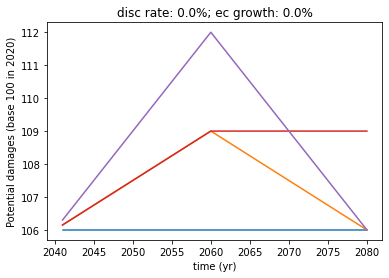

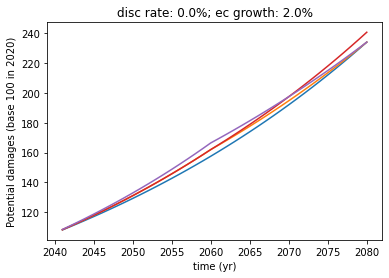

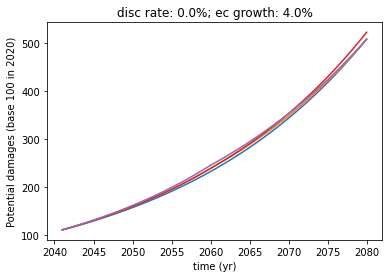

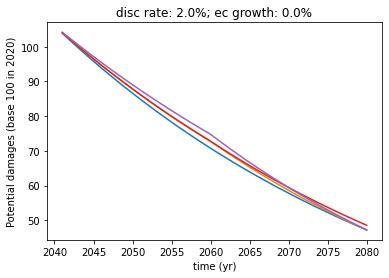

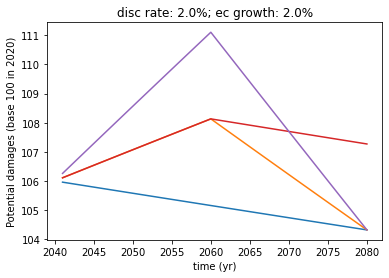

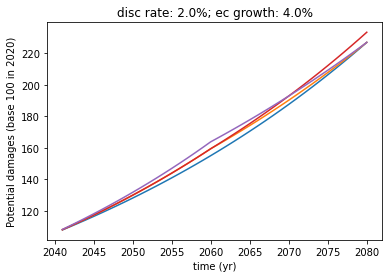

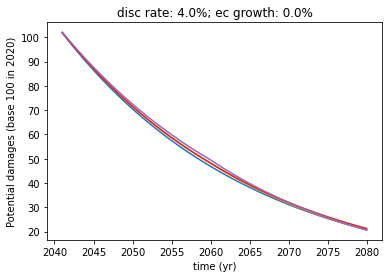

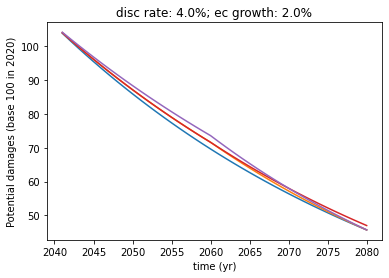

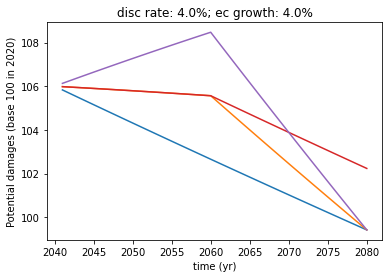

In [200]:
# Plot the potential damages over time

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        plt.figure()

        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],dam[0,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='C0')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],dam[1,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='C1')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],dam[2,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='C3')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],dam[3,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='C4')
    
        plt.title('disc rate: '+str(disc_rate[di])+'%; ec growth: '+str(ec_growth[gr])+'%')
        plt.xlabel('time (yr)')
        plt.ylabel('Potential damages (base 100 in 2020)')
        plt.show()

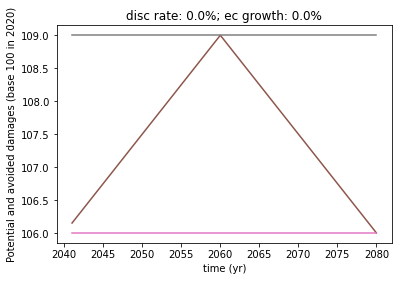

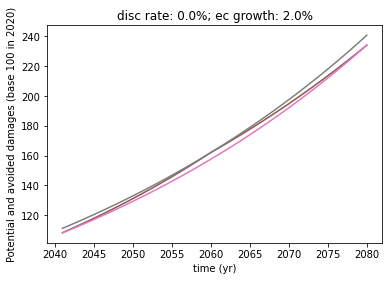

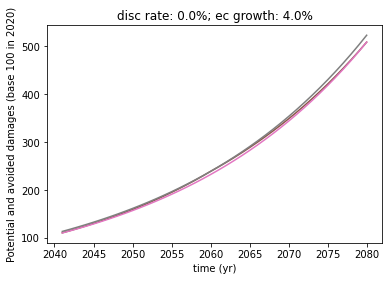

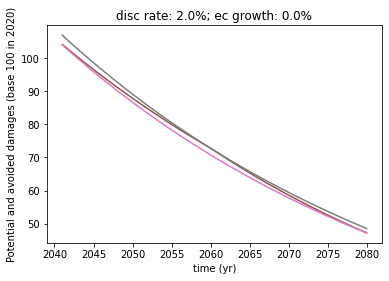

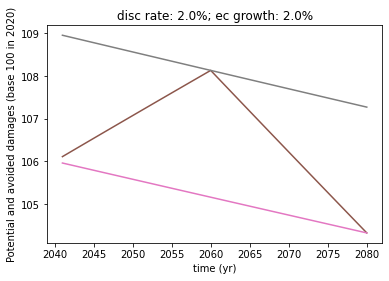

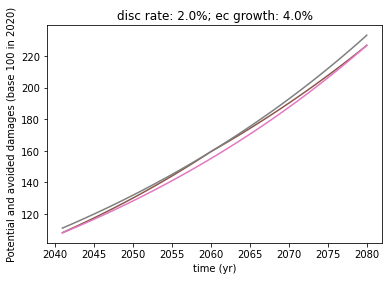

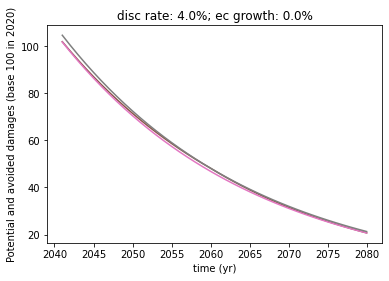

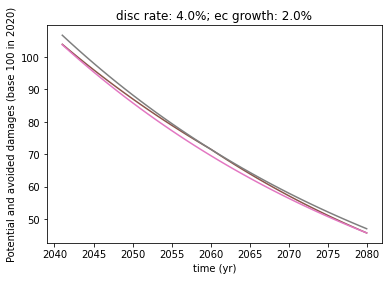

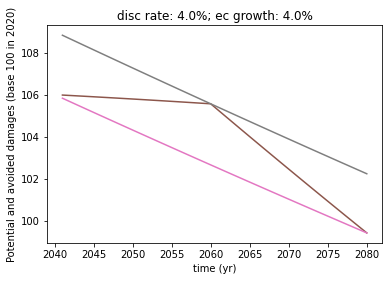

In [220]:
#DEBUGGING
# Plot the potential and avoided damages over time

sc=1
avd=9

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        plt.figure()

        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],dam[sc,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='C5')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],A[0,sc,di,gr,avd,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='C6')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],A[1,sc,di,gr,avd,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='C7')
    
        plt.title('disc rate: '+str(disc_rate[di])+'%; ec growth: '+str(ec_growth[gr])+'%')
        plt.xlabel('time (yr)')
        plt.ylabel('Potential and avoided damages (base 100 in 2020)')
        plt.show()

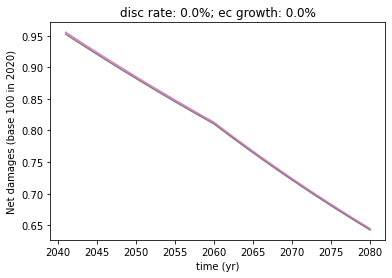

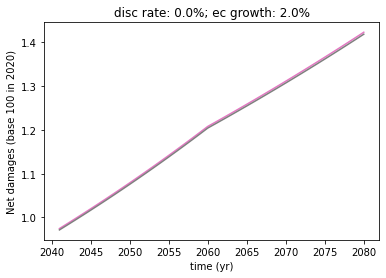

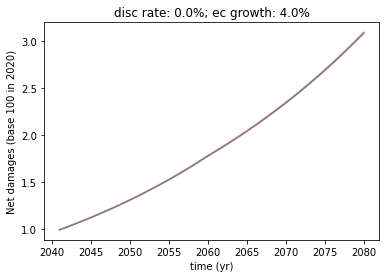

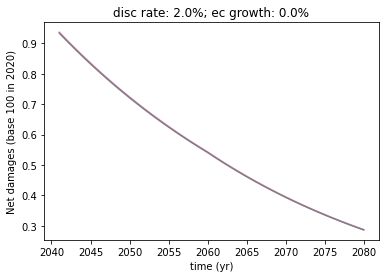

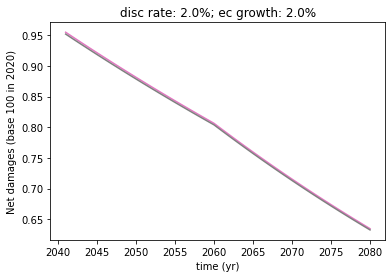

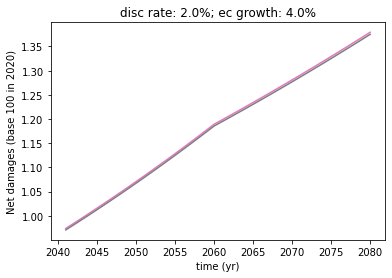

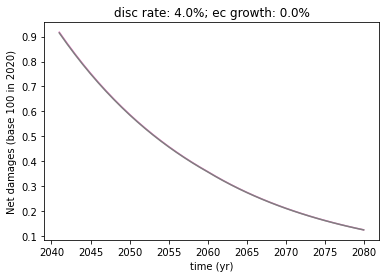

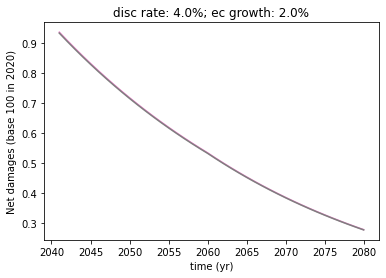

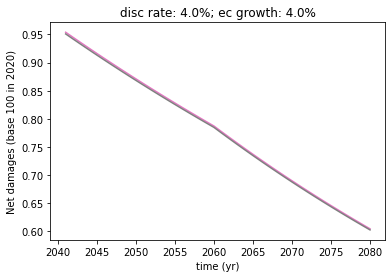

In [218]:
#DEBUGGING
# Plot the net damages over time

sc=1
avd=0

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        plt.figure()

        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],B[0,sc,di,gr,avd,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='C6')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],B[1,sc,di,gr,avd,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='C7')
    
        plt.title('disc rate: '+str(disc_rate[di])+'%; ec growth: '+str(ec_growth[gr])+'%')
        plt.xlabel('time (yr)')
        plt.ylabel('Net damages (base 100 in 2020)')
        plt.show()

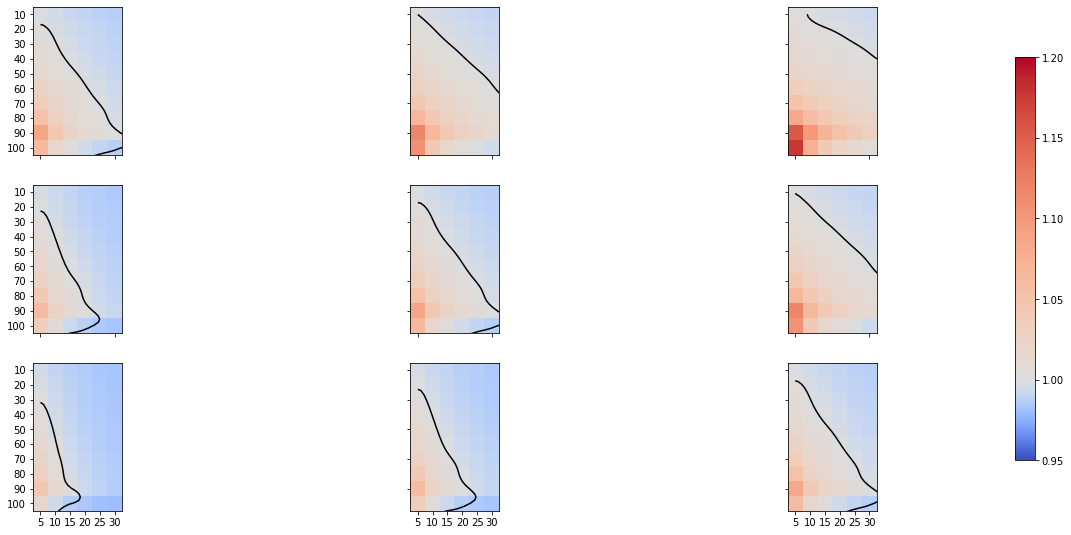

In [215]:
# Plot the ratio of total costs for the various values of the parameters investigated
# discount rates, damage level avoided through adaptation, costs of adaptation


# Define colorbar
colors1 = plt.cm.coolwarm(np.linspace(0, 1, 40))[:20]
colors2 = plt.cm.coolwarm(np.linspace(0, 1, 160))[-80:]
#n_sections = 100
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1,colors2)))#, N=n_sections)


## For the overshoot scenario

axes=[]
fig=plt.figure(figsize=(18,7))

xticklabels = []
for adc in range(len(adcosts_perc_dam)):
    xticklabels.append(str(adcosts_perc_dam[adc]))
    
yticklabels = []
for avd in range(len(perc_av_dam)):
    yticklabels.append(str(perc_av_dam[avd]))

    
smooth_scale = 5

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        axes.append(fig.add_subplot(len(disc_rate), len(ec_growth), di*(len(ec_growth))+gr+1))
        
        z = ndimage.zoom(ratio_costs_options[1,di,gr,:,:], smooth_scale)
        cntr = plt.contour(np.linspace(0, len(adcosts_perc_dam), len(adcosts_perc_dam) * smooth_scale), 
                   np.linspace(0, len(perc_av_dam), len(perc_av_dam) * smooth_scale),
                   z, levels=(0.5,1), colors = 'black')
        
        ax = plt.imshow(ratio_costs_options[1,di,gr,:,:],cmap=my_cmap,vmin=0.95,vmax=1.2)

        if di != len(disc_rate)-1:
            ax.axes.xaxis.set_ticklabels([])
        else:
            plt.xticks(np.arange(len(adcosts_perc_dam)),xticklabels)
            
        if gr != 0:
            ax.axes.yaxis.set_ticklabels([])
        else:
            plt.yticks(np.arange(len(perc_av_dam)),yticklabels)
        

plt.subplots_adjust(bottom=0., right=0.95, top=1.0)
cax = plt.axes([0.97, 0.1, 0.015, 0.8])
plt.colorbar(cax=cax)



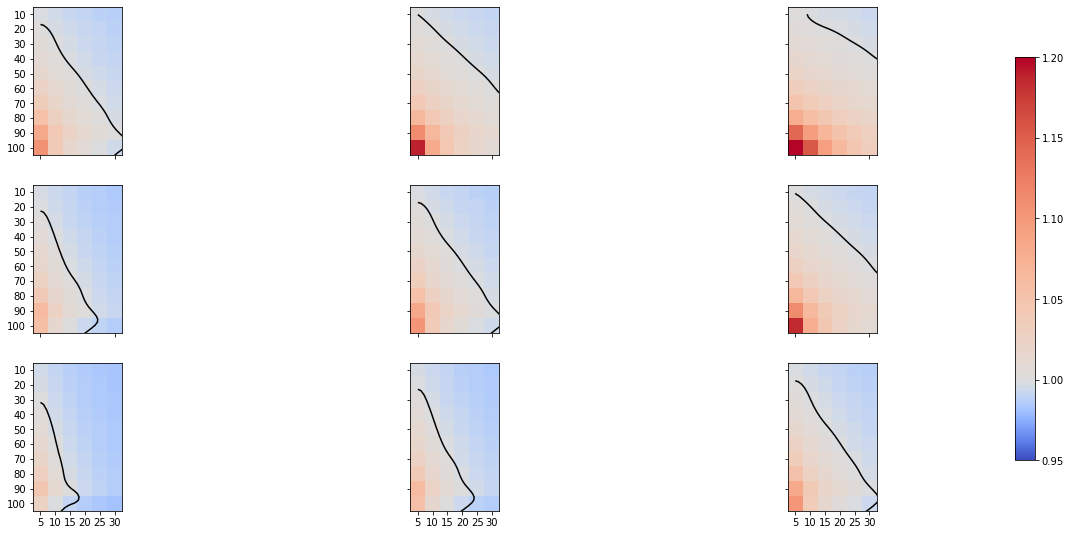

In [216]:
# Plot the ratio of total costs for the various values of the parameters investigated
# discount rates, damage level avoided through adaptation, costs of adaptation


# Define colorbar
colors1 = plt.cm.coolwarm(np.linspace(0, 1, 40))[:20]
colors2 = plt.cm.coolwarm(np.linspace(0, 1, 160))[-80:]
#n_sections = 100
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1,colors2)))#, N=n_sections)


## For the 'stay-at-peak' scenario

axes=[]
fig=plt.figure(figsize=(18,7))

xticklabels = []
for adc in range(len(adcosts_perc_dam)):
    xticklabels.append(str(adcosts_perc_dam[adc]))
    
yticklabels = []
for avd in range(len(perc_av_dam)):
    yticklabels.append(str(perc_av_dam[avd]))

    
smooth_scale = 5

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        axes.append(fig.add_subplot(len(disc_rate), len(ec_growth), di*(len(ec_growth))+gr+1))
        
        z = ndimage.zoom(ratio_costs_options[2,di,gr,:,:], smooth_scale)
        cntr = plt.contour(np.linspace(0, len(adcosts_perc_dam), len(adcosts_perc_dam) * smooth_scale), 
                   np.linspace(0, len(perc_av_dam), len(perc_av_dam) * smooth_scale),
                   z, levels=(0.5,1), colors = 'black')
        
        ax = plt.imshow(ratio_costs_options[2,di,gr,:,:],cmap=my_cmap,vmin=0.95,vmax=1.2)

        if di != len(disc_rate)-1:
            ax.axes.xaxis.set_ticklabels([])
        else:
            plt.xticks(np.arange(len(adcosts_perc_dam)),xticklabels)
            
        if gr != 0:
            ax.axes.yaxis.set_ticklabels([])
        else:
            plt.yticks(np.arange(len(perc_av_dam)),yticklabels)
        

plt.subplots_adjust(bottom=0., right=0.95, top=1.0)
cax = plt.axes([0.97, 0.1, 0.015, 0.8])
plt.colorbar(cax=cax)



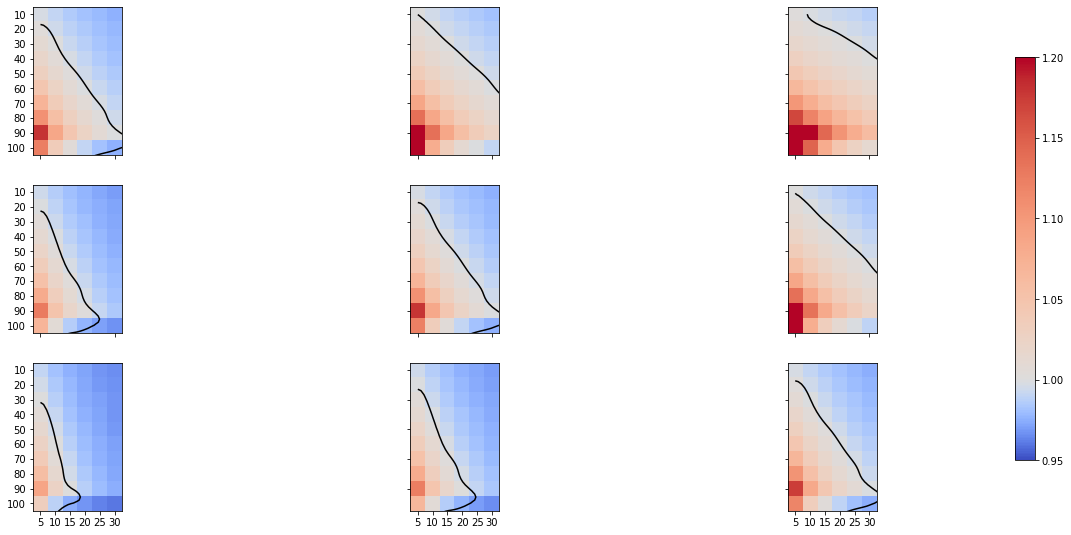

In [217]:
# Plot the ratio of total costs for the various values of the parameters investigated
# discount rates, damage level avoided through adaptation, costs of adaptation


# Define colorbar
colors1 = plt.cm.coolwarm(np.linspace(0, 1, 40))[:20]
colors2 = plt.cm.coolwarm(np.linspace(0, 1, 160))[-80:]
#n_sections = 100
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1,colors2)))#, N=n_sections)


## For the 1.7 overshoot scenario

axes=[]
fig=plt.figure(figsize=(18,7))

xticklabels = []
for adc in range(len(adcosts_perc_dam)):
    xticklabels.append(str(adcosts_perc_dam[adc]))
    
yticklabels = []
for avd in range(len(perc_av_dam)):
    yticklabels.append(str(perc_av_dam[avd]))

    
#cntr = ax.contour(np.linspace(0, len(flights.columns), len(flights.columns) * smooth_scale),
#                  np.linspace(0, len(flights.index), len(flights.index) * smooth_scale),
#                  z, levels=(200, 400), colors='yellow')
smooth_scale = 5

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        axes.append(fig.add_subplot(len(disc_rate), len(ec_growth), di*(len(ec_growth))+gr+1))
        
        z = ndimage.zoom(ratio_costs_options[3,di,gr,:,:], smooth_scale)
        cntr = plt.contour(np.linspace(0, len(adcosts_perc_dam), len(adcosts_perc_dam) * smooth_scale), 
                   np.linspace(0, len(perc_av_dam), len(perc_av_dam) * smooth_scale),
                   z, levels=(0.5,1), colors = 'black')
        
        ax = plt.imshow(ratio_costs_options[3,di,gr,:,:],cmap=my_cmap,vmin=0.95,vmax=1.2)

        if di != len(disc_rate)-1:
            ax.axes.xaxis.set_ticklabels([])
        else:
            plt.xticks(np.arange(len(adcosts_perc_dam)),xticklabels)
            
        if gr != 0:
            ax.axes.yaxis.set_ticklabels([])
        else:
            plt.yticks(np.arange(len(perc_av_dam)),yticklabels)
        

plt.subplots_adjust(bottom=0., right=0.95, top=1.0)
cax = plt.axes([0.97, 0.1, 0.015, 0.8])
plt.colorbar(cax=cax)



In [75]:
## ALTERNATIVE: 
## What happens if one adapts to the future level of impacts but accounting for the discount rate and 

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]])

In [44]:
# OLD: Define GMT scenarios

#GMT=np.zeros((3,len(years)))

## stabilisation at 1.5 in 2050
#for i in range(len(years)):
#    if years[i] <= 2050:
#        GMT[0,i] = 1.5 - (2050-years[i])*(1.5-1.1)/(2050-2020)
#    elif years[i] > 2050:
#        GMT[0,i] = 1.5
    
#print(GMT[0,:])

## peak warming at 1.6 in 2050, coming back to 1.4 in 2100
#for i in range(len(years)):
#    if years[i] <= 2050:
#        GMT[1,i] = 1.6 - (2050-years[i])*(1.6-1.1)/(2050-2020)
#    elif years[i] > 2050:
#        GMT[1,i] = 1.6 - (years[i]-2050)*(1.6-1.4)/(2100-2050)
    
#print(GMT[1,:])

## peak warming at 1.7 in 2050, coming back to 1.4 in 2100
#for i in range(len(years)):
#    if years[i] <= 2050:
#        GMT[2,i] = 1.7 - (2050-years[i])*(1.7-1.1)/(2050-2020)
#    elif years[i] > 2050:
#        GMT[2,i] = 1.7 - (years[i]-2050)*(1.7-1.4)/(2100-2050)
    
#print(GMT[2,:])

In [128]:
#OLD
# Define damage coefficients from global warming

#lin_coeff=[1,5]
#dam_coeff_lin=np.zeros((len(scens),len(lin_coeff),len(years)))  # scenarios, coefficients, time

#for i in range(len(lin_coeff)):
#    dam_coeff_lin[:,i,:] = 1+(i+1)*(GMT-GMT[0,0])/GMT[0,0]
#    print(dam_coeff_lin[:,i,:])

ValueError: could not broadcast input array from shape (4,85) into shape (4,81)

In [ ]:


# OLD

# Plot the damages from Global Warming and corresponding costs of adaptation

#dash_patterns=['solid','dotted','dashed','dashdot','solid']

# assuming damages evolve linearly with GW

#ec_growth = [0,2] # economic growth in percent
#adcosts_perc_dam = 10 # Adaptation costs are set to 10% of the assets (similar to Bresch and Aznar-Siguan, 2021, GMD)

#for gr in range(len(ec_growth)):   # Loop on possible values for the economic growth
    # !!! NEED TO REVISIT WHAT ECONOMIC GROWTH WOUD IMPLY HERE
    
    # calculate value over the years
#    value = 1*((100+ec_growth[gr])/100)**(years-years[0])
#    print(value)

        
    # plot damages
#    plt.figure()
#    for i in range(len(lin_coeff)):
#        plt.plot(years,dam_coeff_lin[0,i,:]*value, color='C0', linestyle=dash_patterns[i])
#        plt.plot(years,dam_coeff_lin[1,i,:]*value, color='C1', linestyle=dash_patterns[i])
#        plt.plot(years,dam_coeff_lin[2,i,:]*value, color='C2', linestyle=dash_patterns[i])
#        plt.plot(years,dam_coeff_lin[3,i,:]*value, color='C3', linestyle=dash_patterns[i])
    
#    plt.title('damages: linear, economic growth: '+str(ec_growth[gr])+'%')
#    plt.xlabel('time (yr)')
#    plt.ylabel('damages')
#    plt.show()

        
    # plot costs of adaptation
#    adcosts_damlin = adcosts_perc_dam/100*dam_coeff_lin*value
    
#    plt.figure()
#    for i in range(len(lin_coeff)):
#        plt.plot(years,adcosts_damlin[0,i,:], color='C0', linestyle=dash_patterns[i])
#        plt.plot(years,adcosts_damlin[1,i,:], color='C1', linestyle=dash_patterns[i])
#        plt.plot(years,adcosts_damlin[2,i,:], color='C2', linestyle=dash_patterns[i])
#        plt.plot(years,adcosts_damlin[3,i,:], color='C3', linestyle=dash_patterns[i])
    
#    plt.title('damages: linear, economic growth: '+str(ec_growth[gr])+'%')
#    plt.xlabel('time (yr)')
#    plt.ylabel('costs of adaptation')
#    plt.show()
        

-11.727361273944183
35.35879283038864


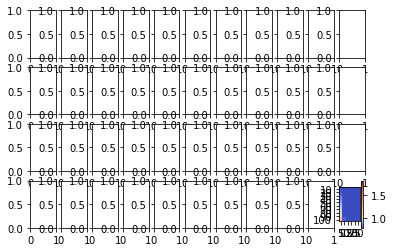

In [45]:
# Plot the ratio of total costs for the various values of the parameters investigated
# discount rates, damage level avoided through adaptation, costs of adaptation

min_ratio = ratio_costs_options.min()
max_ratio = ratio_costs_options.max()
print(min_ratio)
print(max_ratio)

#col_width=17
#row_width=20
#plt.figure(figsize=(col_width, row_width ))

#grid = plt.GridSpec(len(scens)*2, len(disc_rate)*2, wspace=0.01, hspace=0) # create a grid for the subplots #0.12
fig, ax = plt.subplots(nrows=len(scens),ncols=len(disc_rate))


# Create colorbar
colors1 = plt.cm.coolwarm(np.linspace(0, 1, 40))[:20]
colors2 = plt.cm.coolwarm(np.linspace(0, 1, 160))[-80:]
#my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1,colors2)))

n_sections = 100
my_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1,colors2)), N=n_sections)

for sc in range(len(scens)):
    for di in range(len(disc_rate)):

#        print('scenario')
#        print(scens[sc])
#        print('discount rate')
#        print(str(disc_rate[di])+'%')
        
        #plt.figure()
        
        #ax[sc,di] = plt.subplot(grid[sc+1,di+1])
        #ax[sc,di] = plt.subplot.imshow(ratio_costs_options[sc,di,:,:],cmap=my_map,vmin=0.8,vmax=1.8)
        
        #ax = plt.subplot(grid[sc+1,di+1])
        
        ax[sc,di] = plt.imshow(ratio_costs_options[sc,di,:,:],cmap=my_map,vmin=0.8,vmax=1.8)
        
        #plt.imshow(ratio_costs_options[sc,di,:,:],cmap=my_map,vmin=0.8,vmax=1.8)

        plt.xticks(np.arange(len(adcosts_perc_dam)),adcosts_perc_dam)
        plt.yticks(np.arange(len(perc_av_dam)),perc_av_dam)
        #plt.colorbar()
#plt.title('damages: linear')
        #plt.xlabel('adaptation costs (%)')
        #plt.ylabel('avoided damages (%)')
#plt.show()
plt.colorbar()
plt.show()
        
# CHANGE COLOURBARS: red for values above 1, blue for values below 1, covering the range appropriately
# ARRANGE SUBFIGURES

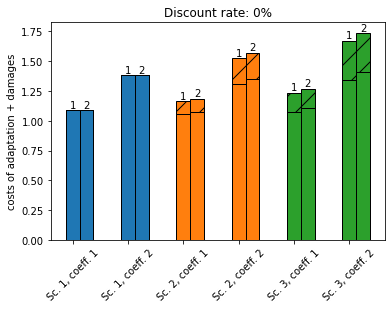

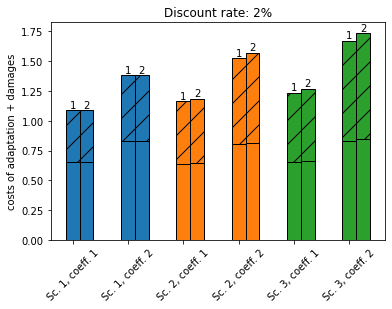

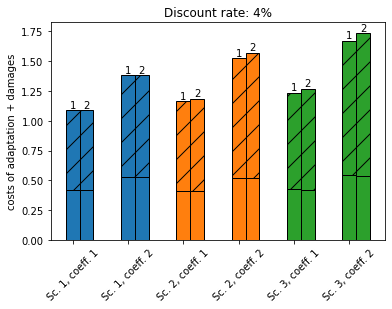

In [281]:
## OLD

# If paying for adaptation in 2050, and assuming a discount rate, 
# what are the avoided damages over the next 30 years and how do they compare to adapting to 2080 levels?

# Plot the total costs = costs of adaptation + damages - avoided damages 

dash_patterns=['solid','dotted','dashed','dashdot','solid']

# assuming damages evolve linearly with GW

disc_rate = [0,2,4] # discount rate

adcosts_perc_dam = 10 # adaptation costs amount to 10% of damages (similar to Bresch and Aznar-Siguan, 2021, GMD)
perc_av_dam = 30  # Percentage of the damages avoided through adaptation

adcosts_damlin = np.empty([2,3,len(lin_coeff)])
max_dam = np.empty((2,3,len(lin_coeff)))
min_dam = np.empty((2,3,len(lin_coeff)))


for di in range(len(disc_rate)):  # Loop on possible values for the discount rate

    # Case 1: adaptation to 2050 damage levels
    
    # costs of adaptation
    adcosts_damlin[0,:,:] = np.squeeze(adcosts_perc_dam/100*dam_coeff_lin[:,:,np.where(years==2050)[0]])

    # max. damages: if 30-year event in 2050, accounting for avoided damages
    dam_lin = dam_coeff_lin[:,:,np.where(years==2050)[0]]
    av_dam_lin = perc_av_dam/100*dam_coeff_lin[:,:,np.where(years==2050)[0]]
    max_dam[0,:,:] = np.squeeze(dam_lin - av_dam_lin)
    #print(max_dam_case1)
    
    # min. damages: if 30-year event in 2080, accounting for avoided damages
    dam_lin = dam_coeff_lin[:,:,np.where(years==2080)[0]]
    min_dam[0,:,:] = np.squeeze((dam_lin - av_dam_lin)*(1-disc_rate[di]/100)**(2080-2050))
    #min_dam[0,:,:] = np.squeeze((1-perc_av_dam/100)*dam_coeff_lin[:,:,np.where(years==2050)[0]]*(1-disc_rate[di]/100)**(2080-2050))
    #print(min_dam_case1)
    
    
    # Case 2: adapt to 2080 damage levels

    # costs of adaptation
    adcosts_damlin[1,:,:] = np.squeeze(adcosts_perc_dam/100*dam_coeff_lin[:,:,np.where(years==2080)[0]])

    # max. damages: if 30-year event in 2050, accounting for avoided damages
    dam_lin = dam_coeff_lin[:,:,np.where(years==2050)[0]]
    av_dam_lin = perc_av_dam/100*dam_coeff_lin[:,:,np.where(years==2080)[0]]
    max_dam[1,:,:] = np.squeeze(dam_lin - av_dam_lin)
    #max_dam[1,:,:] = np.squeeze((1-perc_av_dam/100)*dam_coeff_lin[:,:,np.where(years==2080)[0]])
    
    # min. damages: if 30-year event in 2080, accounting for avoided damages
    dam_lin = dam_coeff_lin[:,:,np.where(years==2080)[0]]
    min_dam[1,:,:] = np.squeeze((dam_lin - av_dam_lin)*(1-disc_rate[di]/100)**(2080-2050))
    #min_dam[1,:,:] = np.squeeze((1-perc_av_dam/100)*dam_coeff_lin[:,:,np.where(years==2080)[0]]*(1-disc_rate[di]/100)**(2080-2050))
    
   
    # PLOT RESULTS
    
    totalcosts_max = np.empty([2,3*len(lin_coeff)])
    totalcosts_min = np.empty([2,3*len(lin_coeff)])                                                        
                                                        
    for i in range(3):
        for j in range(len(lin_coeff)):
            totalcosts_max[0,i*len(lin_coeff)+j] = adcosts_damlin[0,i,j] + max_dam[0,i,j]
            totalcosts_min[0,i*len(lin_coeff)+j] = adcosts_damlin[0,i,j] + min_dam[0,i,j]                                                       
            totalcosts_max[1,i*len(lin_coeff)+j] = adcosts_damlin[1,i,j] + max_dam[1,i,j]
            totalcosts_min[1,i*len(lin_coeff)+j] = adcosts_damlin[1,i,j] + min_dam[1,i,j]
    
    plt.figure()
    labels = ['Sc. 1, coeff. 1', 'Sc. 1, coeff. 2', 'Sc. 2, coeff. 1', 'Sc. 2, coeff. 2', 'Sc. 3, coeff. 1', 'Sc. 3, coeff. 2']
    X = np.arange(len(labels))
    p1 = plt.bar(X + 0.00, totalcosts_max[0,:], width = 0.25, color=['C0','C0','C1','C1','C2','C2'], hatch="/", edgecolor='black')
    p2 = plt.bar(X + 0.25, totalcosts_max[1,:], width = 0.25, color=['C0','C0','C1','C1','C2','C2'], hatch="/", edgecolor='black')
    plt.bar(X + 0.00, totalcosts_min[0,:], width = 0.25, color=['C0','C0','C1','C1','C2','C2'], edgecolor='black')
    plt.bar(X + 0.25, totalcosts_min[1,:], width = 0.25, color=['C0','C0','C1','C1','C2','C2'], edgecolor='black')
    
    plt.bar_label(p1, labels=['1','1','1','1','1','1'])
    plt.bar_label(p2, labels=['2','2','2','2','2','2'])
    plt.xticks(X, labels, rotation=45)
    plt.ylabel('costs of adaptation + damages')
    plt.title('Discount rate: '+str(disc_rate[di])+'%')
    plt.show()
    
                                                              
    # plot cumulated avoided damages if adapting in 2050 to 2050 damage levels
        #av_damlin = np.zeros(3,5,(years[np.where(years == 2050)]-years[np.where(years == 2080)])/step_yr+1)
#        plt.figure()
#        for i in range(len(lin_coeff)):
#            for yr in range(1,int((2080-2050)/step_yr+1)):
#                av_damlin[0,i,yr] = av_damlin[0,i,yr-1] + perc_av_dam*dam_coeff_lin[0,i,np.where(years==2050)[0]+yr]*value[np.where(years==2050)[0]+yr]*(1-disc_rate[di]**yr/100)
#                av_damlin[1,i,yr] = av_damlin[1,i,yr-1] + perc_av_dam*dam_coeff_lin[1,i,np.where(years==2050)[0]+yr]*value[np.where(years==2050)[0]+yr]*(1-disc_rate[di]**yr/100)
#               av_damlin[2,i,yr] = av_damlin[2,i,yr-1] + perc_av_dam*dam_coeff_lin[2,i,np.where(years==2050)[0]+yr]*value[np.where(years==2050)[0]+yr]*(1-disc_rate[di]**yr/100)
                
            #print(years[np.where(years==2050)[0]:])
#            plt.plot(years[int((2050-years[0])/step_yr):int((2080-years[0])/step_yr)+1],av_damlin[0,i,:], color='C0', linestyle=dash_patterns[i])
#            plt.plot(years[int((2050-years[0])/step_yr):int((2080-years[0])/step_yr)+1],av_damlin[1,i,:], color='C1', linestyle=dash_patterns[i])
#            plt.plot(years[int((2050-years[0])/step_yr):int((2080-years[0])/step_yr)+1],av_damlin[2,i,:], color='C2', linestyle=dash_patterns[i])
            
#        plt.title('damages: linear, economic growth: '+str(ec_growth[gr])+'%, discount rate: '+str(disc_rate[di])+'%')
#        plt.xlabel('time (yr)')
#        plt.ylabel('avoided cumulative damages if adapting to 2050 levels')
#        plt.show()
        
        ### 

In [51]:
# Define GMT scenarios

scens = ["stabil_15", "PW_16", "PW_17", "PW_18"]

PW = [1.5, 1.6, 1.7, 1.8]
yr_start = 2020
yr_15_befov = 2040
yr_PW = 2060
yr_15_aftov = 2080

GMT=np.zeros((len(scens),len(years)))

for sc in range(len(scens)):
    for i in range(len(years)):
        if years[i] <= yr_15_befov:
            GMT[sc,i] = 1.5 - (yr_15_befov-years[i])*(1.5-1.2)/(yr_15_befov-yr_start)
        if years[i] > yr_15_befov and years[i] <= yr_PW:       
            GMT[sc,i] = PW[sc] - (yr_PW-years[i])*(PW[sc]-1.5)/(yr_PW-yr_15_befov)
        elif years[i] > yr_PW and years[i] <= yr_15_aftov:
            GMT[sc,i] = PW[sc] - (years[i]-yr_PW)*(PW[sc]-1.5)/(yr_15_aftov-yr_PW)
        elif years[i] > 2060:
            GMT[sc,i] = 1.5

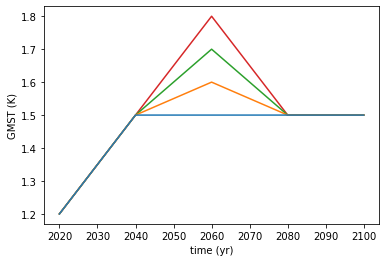

In [52]:
# Plot the GMT trajectories
    
plt.plot(years,GMT[3,:], color='C3')
plt.plot(years,GMT[2,:], color='C2')
plt.plot(years,GMT[1,:], color='C1')
plt.plot(years,GMT[0,:], color='C0')
    
plt.xlabel('time (yr)')
plt.ylabel('GMST (K)')
plt.show()